# Spark Ml-Lib

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F



# Create a Spark session
spark = SparkSession.builder \
    .appName("spark-ml") \
    .master("local[*]").getOrCreate()


df_avocado = spark.read.csv(
  "archive/avocado.csv", 
  header=True, 
  inferSchema=True
)

24/10/19 16:32:12 WARN Utils: Your hostname, munna-Latitude-E7450 resolves to a loopback address: 127.0.1.1; using 192.168.1.106 instead (on interface wlp2s0)
24/10/19 16:32:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/19 16:32:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Import machine learning libraries
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Machine learning pipeline
from pyspark.ml import Pipeline

# Import SQL transformer
from pyspark.ml.feature import SQLTransformer, StandardScaler, StringIndexer

In [3]:
# cache data
df_avocado.cache()
df_avocado.show(4)

24/10/19 16:32:35 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Date, AveragePrice, Total Volume, 4046, 4225, 4770, Total Bags, Small Bags, Large Bags, XLarge Bags, type, year, region
 Schema: _c0, Date, AveragePrice, Total Volume, 4046, 4225, 4770, Total Bags, Small Bags, Large Bags, XLarge Bags, type, year, region
Expected: _c0 but found: 
CSV file: file:///home/munna/airflow-python/archive/avocado.csv


+---+----------+------------+------------+-------+---------+-----+----------+----------+----------+-----------+------------+----+------+
|_c0|      Date|AveragePrice|Total Volume|   4046|     4225| 4770|Total Bags|Small Bags|Large Bags|XLarge Bags|        type|year|region|
+---+----------+------------+------------+-------+---------+-----+----------+----------+----------+-----------+------------+----+------+
|  0|2015-12-27|        1.33|    64236.62|1036.74| 54454.85|48.16|   8696.87|   8603.62|     93.25|        0.0|conventional|2015|Albany|
|  1|2015-12-20|        1.35|    54876.98| 674.28| 44638.81|58.33|   9505.56|   9408.07|     97.49|        0.0|conventional|2015|Albany|
|  2|2015-12-13|        0.93|   118220.22|  794.7|109149.67|130.5|   8145.35|   8042.21|    103.14|        0.0|conventional|2015|Albany|
|  3|2015-12-06|        1.08|    78992.15| 1132.0| 71976.41|72.58|   5811.16|    5677.4|    133.76|        0.0|conventional|2015|Albany|
+---+----------+------------+------------

In [4]:
df_avocado.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- AveragePrice: double (nullable = true)
 |-- Total Volume: double (nullable = true)
 |-- 4046: double (nullable = true)
 |-- 4225: double (nullable = true)
 |-- 4770: double (nullable = true)
 |-- Total Bags: double (nullable = true)
 |-- Small Bags: double (nullable = true)
 |-- Large Bags: double (nullable = true)
 |-- XLarge Bags: double (nullable = true)
 |-- type: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- region: string (nullable = true)



In [5]:
df_avocado_corr = (
    df_avocado[ 
        [
            'Total Volume', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags',
            '4046', '4225', '4770',
            'AveragePrice'
        ] 
    ]
    .toPandas()
    .corr()
)

df_avocado_corr.style.background_gradient(cmap='coolwarm_r')

,Total Volume,Total Bags,Small Bags,Large Bags,XLarge Bags,4046,4225,4770,AveragePrice
Total Volume,1.000000,0.963047,0.967238,0.880640,0.747157,0.977863,0.974181,0.872202,-0.192752
Total Bags,0.963047,1.000000,0.994335,0.943009,0.804233,0.920057,0.905787,0.792314,-0.177088
Small Bags,0.967238,0.994335,1.000000,0.902589,0.806845,0.925280,0.916031,0.802733,-0.174730
Large Bags,0.880640,0.943009,0.902589,1.000000,0.710858,0.838645,0.810015,0.698471,-0.172940
XLarge Bags,0.747157,0.804233,0.806845,0.710858,1.000000,0.699377,0.688809,0.679861,-0.117592
4046,0.977863,0.920057,0.925280,0.838645,0.699377,1.000000,0.926110,0.833389,-0.208317
4225,0.974181,0.905787,0.916031,0.810015,0.688809,0.926110,1.000000,0.887855,-0.172928
4770,0.872202,0.792314,0.802733,0.698471,0.679861,0.833389,0.887855,1.000000,-0.179446
AveragePrice,-0.192752,-0.177088,-0.174730,-0.172940,-0.117592,-0.208317,-0.172928,-0.179446,1.000000


In [6]:
(
    df_avocado[ 
        ['Total Volume', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags'] 
    ]
    .describe()
    .show()
)

24/10/19 16:32:40 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+------------------+------------------+------------------+
|summary|      Total Volume|        Total Bags|        Small Bags|        Large Bags|       XLarge Bags|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|             18249|             18249|             18249|             18249|             18249|
|   mean| 850644.0130089332|239639.20205983953|182194.68669571026| 54338.08814455636|3106.4265072058793|
| stddev|3453545.3553994684| 986242.3992164108| 746178.5149617895|243965.96454740898| 17692.89465191642|
|    min|             84.56|               0.0|               0.0|               0.0|               0.0|
|    max|     6.250564652E7|     1.937313437E7|      1.33845868E7|        5719096.61|         551693.65|
+-------+------------------+------------------+------------------+------------------+------------------+



In [7]:
(
    df_avocado[ 
        ['Total Volume', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags'] 
    ]
    .toPandas()
    .corr()
)

,Total Volume,Total Bags,Small Bags,Large Bags,XLarge Bags
Total Volume,1.000000,0.963047,0.967238,0.880640,0.747157
Total Bags,0.963047,1.000000,0.994335,0.943009,0.804233
Small Bags,0.967238,0.994335,1.000000,0.902589,0.806845
Large Bags,0.880640,0.943009,0.902589,1.000000,0.710858
XLarge Bags,0.747157,0.804233,0.806845,0.710858,1.000000


In [8]:
(
    df_avocado[ 
        ['4046', '4225', '4770'] 
    ]
    .describe()
    .show()
)

+-------+------------------+------------------+------------------+
|summary|              4046|              4225|              4770|
+-------+------------------+------------------+------------------+
|  count|             18249|             18249|             18249|
|   mean|293008.42453066056|295154.56835607596|22839.735992657315|
| stddev|1264989.0817627835|1204120.4011350533|107464.06843537069|
|    min|               0.0|               0.0|               0.0|
|    max|     2.274361617E7|     2.047057261E7|        2546439.11|
+-------+------------------+------------------+------------------+



In [9]:
(
    df_avocado[ 
        ['4046', '4225', '4770']
    ]
    .toPandas()
    .corr()
)

,4046,4225,4770
4046,1.000000,0.926110,0.833389
4225,0.926110,1.000000,0.887855
4770,0.833389,0.887855,1.000000


In [10]:
(df_avocado[[['type']]]
 .groupBy("type")
 .count()
 .toPandas())

,type,count
0,organic,9123
1,conventional,9126


In [11]:
(
    df_avocado[ 
        ['region'] 
    ]
    .groupBy('region')
    .count()
    .show(10)
)

+----------------+-----+
|          region|count|
+----------------+-----+
|   PhoenixTucson|  338|
|     GrandRapids|  338|
|   SouthCarolina|  338|
|         TotalUS|  338|
|WestTexNewMexico|  335|
|      Louisville|  338|
|    Philadelphia|  338|
|      Sacramento|  338|
|   DallasFtWorth|  338|
|    Indianapolis|  338|
+----------------+-----+
only showing top 10 rows



In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

/tmp/ipykernel_492687/1612995206.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


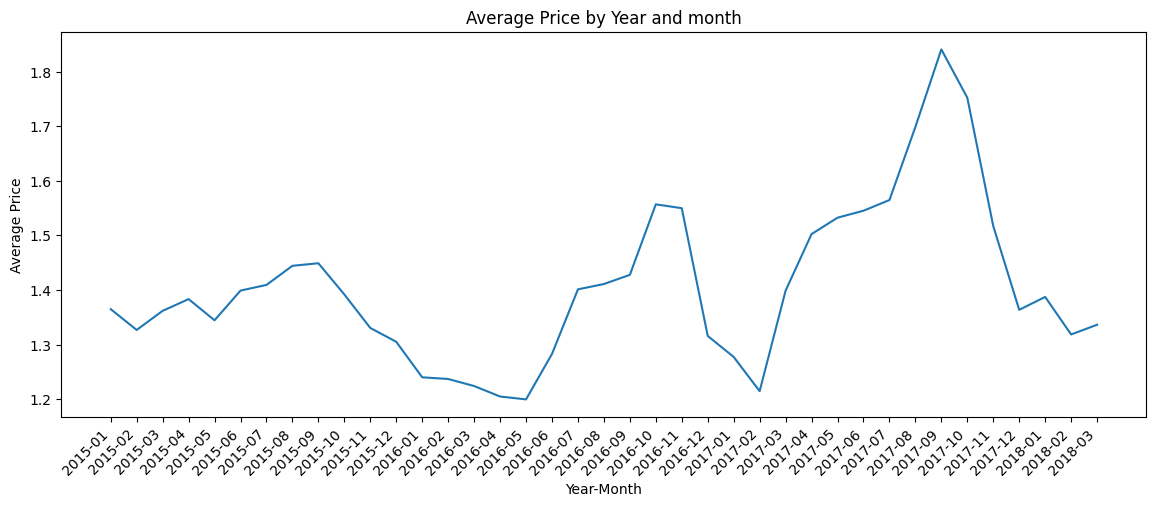

In [16]:
## Monthly Average Price
df_mean_monthly_price = (
    df_avocado
    .withColumn('Date', F.to_date('Date'))
    .withColumn('Date', F.date_format('Date', 'yyyy-MM'))
    .groupBy('Date')
    .agg(F.mean('AveragePrice').alias('AveragePrice'))
    .orderBy('Date')
)

## Plot the result
fig, ax = plt.subplots(figsize=(14, 5))

ax = sns.lineplot(
    x='Date', y='AveragePrice',
    data=df_mean_monthly_price.toPandas(),
    ax=ax,
)

ax.set_title('Average Price by Year and month')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Average Price')

ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right'
)
ax=ax

/tmp/ipykernel_492687/1141469730.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


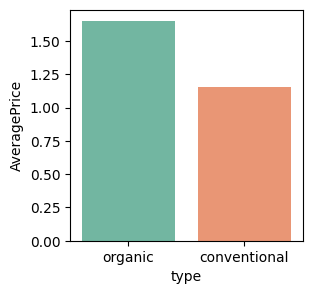

In [21]:
# Calculate the mean price per type
df_mean_price_type = (
    df_avocado
    .groupBy('type')
    .agg(F.mean('AveragePrice').alias('AveragePrice'))
)

# Plot the result with custom colors
fig, ax = plt.subplots(figsize=(3, 3))

# Use a color palette for the barplot
ax = sns.barplot(
    x='type', 
    y='AveragePrice',
    data=df_mean_price_type.toPandas(),
    ax=ax,
    palette="Set2"  # You can change the palette to any other Seaborn palette
)

# Show the plot
plt.show()

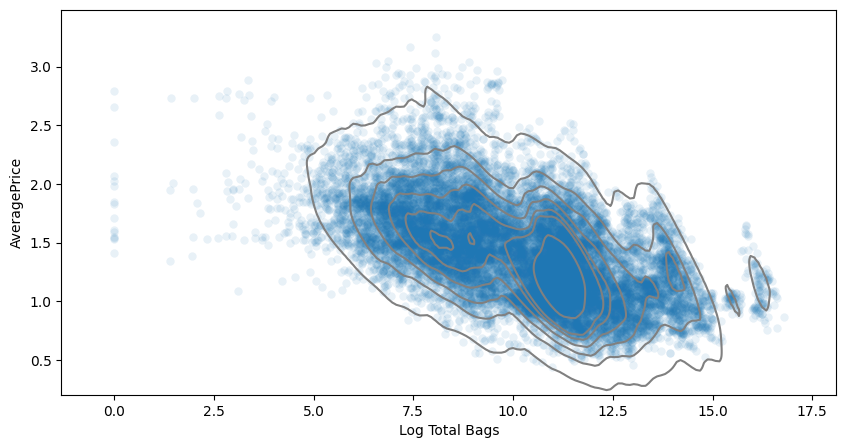

In [20]:
# Scatter plot price vs number of bags

# log Total Bags+1
df_avocado = df_avocado.withColumn('Log Total Bags', F.log(F.col('Total Bags')+1))

fig, ax = plt.subplots(figsize=(10, 5))

# Add a contour plot
ax = sns.scatterplot(
    x='Log Total Bags', y='AveragePrice',
    data=df_avocado.toPandas(),
    alpha=0.1,
    linewidth=0,
    ax=ax,
)

ax = sns.kdeplot(
    x='Log Total Bags', y='AveragePrice',
    data=df_avocado.toPandas(),
    levels=8,
    color='gray',
    ax=ax,
)

In [22]:
df_corr_plu = (
    df_avocado
    .select(
        'AveragePrice',
        '4046', '4225', '4770',
    )
    .toPandas()
    .corr()
)

df_corr_plu.style.background_gradient(cmap='coolwarm_r')

,AveragePrice,4046,4225,4770
AveragePrice,1.000000,-0.208317,-0.172928,-0.179446
4046,-0.208317,1.000000,0.926110,0.833389
4225,-0.172928,0.926110,1.000000,0.887855
4770,-0.179446,0.833389,0.887855,1.000000


: 

## Conclusion

Discard columns due to high correlation

* Total Bags (correlated with Small Bags, Large Bags, XLarge Bags)
    + 1
    + 1
* Total Volume
* 4046 (correlated with Total Volume)

## Training Code

In [6]:
df_avocado_train, df_avocado_test = df_avocado.randomSplit([0.75, 0.25], seed=214)

In [7]:
COLUMNS = ['AveragePrice', 'type']
COLUMNS = [f"`{col}`" for col in COLUMNS]

LOG_COLUMNS =  ['4225', '4770', 'Small Bags', 'Large Bags', 'XLarge Bags']
LOG_COLUMNS = [f"LOG(`{col}`+1) AS `LOG {col}`" for col in LOG_COLUMNS]

sql_trans = SQLTransformer(
    statement=f"""
    
    SELECT
    {', '.join(COLUMNS)}
    , {', '.join(LOG_COLUMNS)}
    ,YEAR(__THIS__.Date)-2000 AS year
    ,MONTH(__THIS__.Date) AS month

    FROM __THIS__

    """
)

# Visualize the data
sql_trans.transform(df_avocado_train).show(4)

+------------+------------+------------------+------------------+------------------+------------------+-----------------+----+-----+
|AveragePrice|        type|          LOG 4225|          LOG 4770|    LOG Small Bags|    LOG Large Bags|  LOG XLarge Bags|year|month|
+------------+------------+------------------+------------------+------------------+------------------+-----------------+----+-----+
|        0.49|conventional|12.566747374652527| 9.362499927974252|11.166908098190957|10.313733879047971|              0.0|  15|   12|
|        0.71|conventional|11.860764002611406| 9.647818872531012| 11.72123326879331| 10.40627082310141|9.322865162818028|  15|   12|
|         0.8|conventional| 12.53017497505446|11.349393905288467|11.824526973139381| 9.415621332905047|9.658771095406955|  15|   12|
|         0.8|conventional|13.028501871764691|11.364461534887267|13.490872079413348| 11.21667384527801|9.342104328605496|  15|   12|
+------------+------------+------------------+------------------+----

In [8]:
from pyspark.ml.feature import MinMaxScaler

month_vec_ass = VectorAssembler(inputCols=['month'], outputCol='month_vec')
month_vec_ass.transform(sql_trans.transform(df_avocado_train))

df_avocado_month_ass = month_vec_ass.transform(sql_trans.transform(df_avocado_train))

month_scaler = MinMaxScaler(inputCol='month_vec', outputCol='month_scaled')
month_scaler = month_scaler.fit(df_avocado_month_ass)

month_scaler.transform(df_avocado_month_ass).select( ['month', 'month_vec', 'month_scaled'] ).show(10)

+-----+---------+------------+
|month|month_vec|month_scaled|
+-----+---------+------------+
|   12|   [12.0]|       [1.0]|
|   12|   [12.0]|       [1.0]|
|   12|   [12.0]|       [1.0]|
|   12|   [12.0]|       [1.0]|
|   12|   [12.0]|       [1.0]|
|   12|   [12.0]|       [1.0]|
|   12|   [12.0]|       [1.0]|
|   12|   [12.0]|       [1.0]|
|   12|   [12.0]|       [1.0]|
|   12|   [12.0]|       [1.0]|
+-----+---------+------------+
only showing top 10 rows



In [9]:
str_indexer = StringIndexer(inputCol="type", outputCol="type_index")

str_indexer = str_indexer.fit(df_avocado_train)

str_indexer.transform(df_avocado_train).select( ["type", "type_index"] ).show(4)

+------------+----------+
|        type|type_index|
+------------+----------+
|conventional|       0.0|
|conventional|       0.0|
|conventional|       0.0|
|conventional|       0.0|
+------------+----------+
only showing top 4 rows



In [10]:
# Apply transformations
## SQL transformer
df_avocado_train_transformed = sql_trans.transform(df_avocado_train)

## String indexer
df_avocado_train_transformed = str_indexer.transform(df_avocado_train_transformed)

## Month scaler (vector assembler + minmax scaler)
df_avocado_train_transformed = month_vec_ass.transform(df_avocado_train_transformed)
df_avocado_train_transformed = month_scaler.transform(df_avocado_train_transformed)

# Join all features into a single vector
numerical_vec_ass = VectorAssembler(
    inputCols=['year', 'month_scaled', 'LOG 4225', 'LOG 4770', 'LOG Small Bags', 'LOG Large Bags', 'LOG XLarge Bags'],
    outputCol='features_num'
)
df_avocado_train_transformed = numerical_vec_ass.transform(df_avocado_train_transformed)

# Join all categorical features into a single vector
categorical_vec_ass = VectorAssembler(
    inputCols=['type_index'],
    outputCol='features_cat'
)
df_avocado_train_transformed = categorical_vec_ass.transform(df_avocado_train_transformed)


# See the result
df_avocado_train_transformed.select(['features_cat', 'features_num', 'AveragePrice']).show(4, False)

+------------+-------------------------------------------------------------------------------------------------------+------------+
|features_cat|features_num                                                                                           |AveragePrice|
+------------+-------------------------------------------------------------------------------------------------------+------------+
|[0.0]       |[15.0,1.0,12.566747374652527,9.362499927974252,11.166908098190957,10.313733879047971,0.0]              |0.49        |
|[0.0]       |[15.0,1.0,11.860764002611406,9.647818872531012,11.72123326879331,10.40627082310141,9.322865162818028]  |0.71        |
|[0.0]       |[15.0,1.0,12.53017497505446,11.349393905288467,11.824526973139381,9.415621332905047,9.658771095406955] |0.8         |
|[0.0]       |[15.0,1.0,13.028501871764691,11.364461534887267,13.490872079413348,11.21667384527801,9.342104328605496]|0.8         |
+------------+--------------------------------------------------------------

In [11]:
std_scaler = StandardScaler(
    inputCol="features_num",
    outputCol="features_scaled",
    withStd=True,
    withMean=True
)

std_scaler = std_scaler.fit(df_avocado_train_transformed)
std_scaler.transform(df_avocado_train_transformed).select(['features_scaled']).show(5, False)

+----------------------------------------------------------------------------------------------------------------------------------------+
|features_scaled                                                                                                                         |
+----------------------------------------------------------------------------------------------------------------------------------------+
|[-1.2177154955881637,1.6482225355667333,0.9527463109714546,1.0269649008115518,0.5657377199959452,0.8334134211814762,-0.6436162273445295]|
|[-1.2177154955881637,1.6482225355667333,0.7058305701685025,1.0954357394643428,0.7803295242390127,0.8574417380503548,2.012648481596976]  |
|[-1.2177154955881637,1.6482225355667333,0.9399552148956506,1.5037797059140563,0.8203168521795554,0.6002078289352569,2.1083545825302594] |
|[-1.2177154955881637,1.6482225355667333,1.1142436751287843,1.5073956355774096,1.4653967110976907,1.0678725104034048,2.0181300922626053] |
|[-1.2177154955881637,1.648

In [12]:
# Create a pipeline
prepro_pipe = Pipeline(stages=[
    sql_trans,
    str_indexer,
    month_vec_ass,
    month_scaler,
    numerical_vec_ass,
    categorical_vec_ass,
    std_scaler,

    # Join all features into a single vector
    VectorAssembler(
        inputCols=['features_scaled', 'features_cat'],
        outputCol='features'
    ),
])


# Fit the pipeline
pipeline_model = prepro_pipe.fit(df_avocado_train)

# Transform the data
df_avocado_train_transformed = pipeline_model.transform(df_avocado_train)

# See the result
df_avocado_train_transformed.select(['features', 'AveragePrice']).show(4, False)

+--------------------------------------------------------------------------------------------------------------------------------------------+------------+
|features                                                                                                                                    |AveragePrice|
+--------------------------------------------------------------------------------------------------------------------------------------------+------------+
|[-1.2177154955881637,1.6482225355667333,0.9527463109714546,1.0269649008115518,0.5657377199959452,0.8334134211814762,-0.6436162273445295,0.0]|0.49        |
|[-1.2177154955881637,1.6482225355667333,0.7058305701685025,1.0954357394643428,0.7803295242390127,0.8574417380503548,2.012648481596976,0.0]  |0.71        |
|[-1.2177154955881637,1.6482225355667333,0.9399552148956506,1.5037797059140563,0.8203168521795554,0.6002078289352569,2.1083545825302594,0.0] |0.8         |
|[-1.2177154955881637,1.6482225355667333,1.1142436751287843,1.50

In [13]:
from pyspark.ml.regression import LinearRegression, RandomForestRegressor

from pyspark.ml.evaluation import RegressionEvaluator

In [14]:
# Create a linear regression model
lin_reg = LinearRegression(
    featuresCol='features',
    labelCol='AveragePrice',
    predictionCol='prediction',
    maxIter=1000,
    regParam=0.3,       # Regularization
    elasticNetParam=0.8 # Regularization mixing parameter. 1 for L1, 0 for L2.
)

# Explain parameter 
print(lin_reg.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 0.8)
epsilon: The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber (default: 1.35)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: AveragePrice)
loss: The loss function to be optimized. Supported options: squaredError, huber. (default: squaredError)
maxBlockSizeInMB: maximum memory in MB for stacking input data into blocks. Data is stacked within partitions. If more than remaining data size in a partition then it is adjusted to the data size. Default 0.0 represents choosing optimal value, depends on specific algorithm. Must be >= 0. (default: 0.0)
maxIter

In [15]:
# Fit the model
lin_reg_model = lin_reg.fit(df_avocado_train_transformed)

# See the output
df_avocado_train_pred = lin_reg_model.transform(df_avocado_train_transformed)
df_avocado_train_pred.select(['features', 'AveragePrice', 'prediction']).show(4, False)

24/10/19 11:12:58 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


+--------------------------------------------------------------------------------------------------------------------------------------------+------------+------------------+
|features                                                                                                                                    |AveragePrice|prediction        |
+--------------------------------------------------------------------------------------------------------------------------------------------+------------+------------------+
|[-1.2177154955881637,1.6482225355667333,0.9527463109714546,1.0269649008115518,0.5657377199959452,0.8334134211814762,-0.6436162273445295,0.0]|0.49        |1.4003505112793717|
|[-1.2177154955881637,1.6482225355667333,0.7058305701685025,1.0954357394643428,0.7803295242390127,0.8574417380503548,2.012648481596976,0.0]  |0.71        |1.4003505112793717|
|[-1.2177154955881637,1.6482225355667333,0.9399552148956506,1.5037797059140563,0.8203168521795554,0.6002078289352569,2.108354

In [16]:
reg_eval = RegressionEvaluator(
    labelCol='AveragePrice',
    predictionCol='prediction',
    metricName='rmse' # Root mean squared error
)

# Evaluate the model
reg_eval.evaluate(df_avocado_train_pred)

0.3978489578943717

In [17]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from pyspark.ml.evaluation import RegressionEvaluator


In [18]:
ml_pipeline = Pipeline(stages=[
    prepro_pipe, # Preprocessing pipeline
    lin_reg     # Linear regression model
])

In [19]:
param_grid = ParamGridBuilder() \
    .addGrid(lin_reg.regParam, [0.0, 0.1, 0.3, 0.5]) \
    .addGrid(lin_reg.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

In [20]:
reg_eval = RegressionEvaluator(
    labelCol='AveragePrice',
    predictionCol='prediction',
    metricName='rmse' # Root mean squared error
)

In [21]:
crossval_ml = CrossValidator(
    estimator=ml_pipeline, 
    estimatorParamMaps=param_grid, 
    evaluator=reg_eval, 
    numFolds=4
)

In [22]:
crossval_ml_model = crossval_ml.fit(df_avocado_train)

24/10/19 11:14:51 WARN Instrumentation: [77e8d0bf] regParam is zero, which might cause numerical instability and overfitting.
24/10/19 11:14:52 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
24/10/19 11:14:54 WARN Instrumentation: [76caa034] regParam is zero, which might cause numerical instability and overfitting.
24/10/19 11:14:57 WARN Instrumentation: [21d4fd0a] regParam is zero, which might cause numerical instability and overfitting.
24/10/19 11:15:19 WARN Instrumentation: [5c5e5ee6] regParam is zero, which might cause numerical instability and overfitting.
24/10/19 11:15:21 WARN Instrumentation: [4998a9e7] regParam is zero, which might cause numerical instability and overfitting.
24/10/19 11:15:23 WARN Instrumentation: [985637c1] regParam is zero, which might cause numerical instability and overfitting.
24/10/19 11:15:40 WARN Instrumentation: [1ccbab6e] regParam is zero, which might cause numerical instability and overfitting.
24/10/1

In [23]:
best_model = crossval_ml_model.bestModel
best_score = crossval_ml_model.avgMetrics[0]

print("Best model: ", best_model)
print("Best score: ", best_score)

Best model:  PipelineModel_87d642091415
Best score:  0.28336442946071916


In [24]:
best_lin_reg_params = best_model.stages[-1].extractParamMap()

print("Best score (RMSE):", best_score, end="\n\n")
for parameter, value in best_lin_reg_params.items():
    print(f"{str(parameter):50s}, {value}")

Best score (RMSE): 0.28336442946071916

LinearRegression_51ef7e737b1f__aggregationDepth   , 2
LinearRegression_51ef7e737b1f__elasticNetParam    , 0.0
LinearRegression_51ef7e737b1f__epsilon            , 1.35
LinearRegression_51ef7e737b1f__featuresCol        , features
LinearRegression_51ef7e737b1f__fitIntercept       , True
LinearRegression_51ef7e737b1f__labelCol           , AveragePrice
LinearRegression_51ef7e737b1f__loss               , squaredError
LinearRegression_51ef7e737b1f__maxBlockSizeInMB   , 0.0
LinearRegression_51ef7e737b1f__maxIter            , 1000
LinearRegression_51ef7e737b1f__predictionCol      , prediction
LinearRegression_51ef7e737b1f__regParam           , 0.0
LinearRegression_51ef7e737b1f__solver             , auto
LinearRegression_51ef7e737b1f__standardization    , True
LinearRegression_51ef7e737b1f__tol                , 1e-06


In [25]:
# Creating a dummy regression model

# Mean price
mean_price = df_avocado_train.agg(F.mean('AveragePrice')).collect()[0][0]
median_price = df_avocado_train.approxQuantile('AveragePrice', [0.5], 0.25)[0]

mean_dummy_df = df_avocado_train.select('AveragePrice').withColumn('prediction', F.lit(mean_price))
median_dummy_df = df_avocado_train.select('AveragePrice').withColumn('prediction', F.lit(median_price))

# Evaluate the dummy models
print(reg_eval.evaluate(mean_dummy_df))
print(reg_eval.evaluate(median_dummy_df))

0.40128919777533023
0.5046357636762134


In [26]:
df_avocado_test_pred = best_model.transform(df_avocado_test)

# show scores
print(reg_eval.evaluate(df_avocado_test_pred))

0.28368085199676235
